In [1]:
import cv2
import numpy as np
import os
import torch
import torch.nn.functional as F
from torchvision.transforms import Compose
from tqdm import tqdm

from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

import matplotlib.pyplot as plt

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [3]:
depth_anything = DepthAnything.from_pretrained('LiheYoung/depth_anything_{}14'.format('vitb')).to(DEVICE).eval()
    
total_params = sum(param.numel() for param in depth_anything.parameters())
print('Total parameters: {:.2f}M'.format(total_params / 1e6))
    
transform = Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
])

Total parameters: 97.47M


In [19]:
def get_depth(img: np.ndarray) -> np.ndarray:
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

    h, w = image.shape[:2]
    
    image = transform({'image': image})['image']
    image = torch.from_numpy(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        depth = depth_anything(image)

    depth = F.interpolate(depth[None], (h, w), mode='bilinear', align_corners=False)[0, 0]
    #depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
        
    #depth = depth.cpu().numpy().astype(np.uint8)

    return depth
    #return np.repeat(depth[..., np.newaxis], 3, axis=-1)

In [5]:
img_pose_file = "/home/jason/ROS/bags/analysis/pose.txt"
img_pose = list()

f = open(img_pose_file, "r")
content = f.readlines()

In [6]:
frame1 = content[75].split(',')
frame2 = content[76].split(',')

frame1_pose = (float(frame1[1]), float(frame1[2]), float(frame1[3]))
frame1_img = frame1[0]

frame2_pose = (float(frame2[1]), float(frame2[2]), float(frame2[3]))
frame2_img = frame2[0]

In [7]:
img1 = cv2.imread("/home/jason/ROS/bags/images/wp_ground/"+frame1_img)
img2 = cv2.imread("/home/jason/ROS/bags/images/wp_ground/"+frame2_img)

pose_change = (frame1_pose[0]-frame2_pose[0],
               frame1_pose[1]-frame2_pose[1],
               frame1_pose[2]-frame2_pose[2])
pose_change

(0.10934988782966126, 0.2349110031676913, 0.014778104339624676)

In [20]:
depth1 = get_depth(img1)
depth2 = get_depth(img2)

82.947105


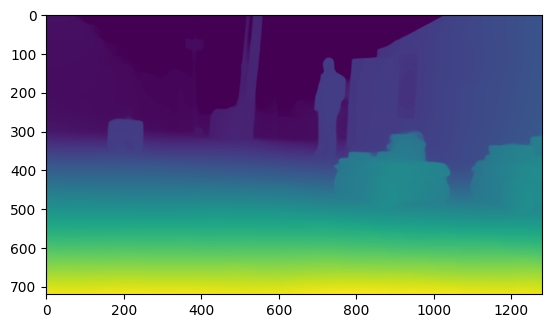

In [21]:
depth1 = depth1.cpu().numpy()
depth2 = depth2.cpu().numpy()
plt.imshow(depth1)
print(depth1.max())

(1280,)


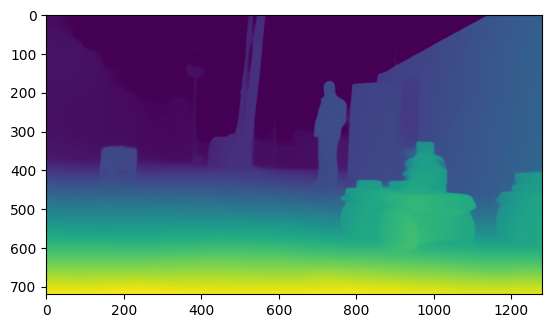

In [22]:
plt.imshow(depth2)
print(depth2[0].shape)

In [23]:
# pick an object compute the difference
u = (250,850) #door
v = (550,900) #jackal
door_d1 = depth1[u[0]][u[1]]
door_d2 = depth2[u[0]][u[1]]

j_d1 = depth1[v[0]][v[1]]
j_d2 = depth2[v[0]][v[1]]

print("Door Depth at D1: %s, and D2: %s" %(door_d1,door_d2))
print("jackal Depth at D1: %s, and D2: %s" %(j_d1,j_d2))

Door Depth at D1: 14.356607, and D2: 16.221046
jackal Depth at D1: 48.845703, and D2: 51.548916


In [24]:
dist_traveled = np.linalg.norm(np.array(pose_change))
delta_pixels_1 = abs(door_d1-door_d2)
delta_pixels_2 = abs(j_d1-j_d2)

# traveling dist equates to delta change in pixel value
# what does change of 1 pixel value equate to in distance
dp_norm = dist_traveled / delta_pixels_1.item()
j_norm = dist_traveled / delta_pixels_2.item()
print("Distance traveled [ Door ] %s | delta pixels: %s | normalized: %s" %(dist_traveled, round(delta_pixels_1.item(),8), dp_norm))
print("Distance traveled [Jackal] %s | delta pixels: %s | normalized: %s" %(dist_traveled, round(delta_pixels_2.item(),8), j_norm))

Distance traveled [ Door ] 0.2595360663674384 | delta pixels: 1.86443901 | normalized: 0.13920330184526447
Distance traveled [Jackal] 0.2595360663674384 | delta pixels: 2.70321274 | normalized: 0.09601022617106192


In [25]:
print("Min value: ", torch.min(depth1[depth1>0]).item())
print("Max value: ", torch.max(depth1).item())

print("Min value: ", torch.min(depth2[depth2>0]).item())
print("Max value: ", torch.max(depth2).item())

TypeError: min(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [26]:
depth1 = depth1 / depth1.max()
depth2 = depth2 / depth2.max()

In [28]:
u = (250,850) #door
v = (550,900) #jackal
door_d1 = depth1[u[0]][u[1]]
door_d2 = depth2[u[0]][u[1]]

j_d1 = depth1[v[0]][v[1]]
j_d2 = depth2[v[0]][v[1]]

print("Door Depth at D1: %s, and D2: %s" %(door_d1,door_d2))
print("jackal Depth at D1: %s, and D2: %s" %(j_d1,j_d2))

dist_traveled = np.linalg.norm(np.array(pose_change))
delta_pixels_1 = abs(door_d1-j_d1)
delta_pixels_2 = abs(door_d2-j_d2)

# traveling dist equates to delta change in pixel value
# what does change of 1 pixel value equate to in distance
dp_norm = dist_traveled / delta_pixels_1.item()
j_norm = dist_traveled / delta_pixels_2.item()
print("Distance traveled [ Door ] %s | delta pixels: %s | normalized: %s" %(dist_traveled, round(delta_pixels_1.item(),8), dp_norm))
print("Distance traveled [Jackal] %s | delta pixels: %s | normalized: %s" %(dist_traveled, round(delta_pixels_2.item(),8), j_norm))

Door Depth at D1: 0.17308147, and D2: 0.2063728
jackal Depth at D1: 0.58887774, and D2: 0.65583277
Distance traveled [ Door ] 0.2595360663674384 | delta pixels: 0.41579628 | normalized: 0.6241904483256722
Distance traveled [Jackal] 0.2595360663674384 | delta pixels: 0.44945997 | normalized: 0.5774397803856399
